In [1]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit -*-
# -*- date : 2023-11-25 -*-
# -*- Last revision: 2023-11-25 -*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarize results-*-

# <center> CS -433 Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Road Segmentation </center>
---

### Preparing environment for Google Colaboratory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ml-project-2-team-slo/source

/content/drive/MyDrive/ml-project-2-team-slo/source


### Imports

In [4]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from constants import *

#import model parameters
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
%load_ext autoreload
%autoreload 2

In [5]:
#import files
from data_processing import*
from visualization import visualize, visualize_patch
from test_data import TestData

#import models
from cnn import Basic_CNN, Advanced_CNN
from logistic_regression import LogisticRegression

In [6]:
# Set random seed for reproducibility
torch.manual_seed(0)

## 1. Data wrangling and visualization

In [ ]:
myDatas = AdvancedProcessing(standardize=False, aug_patch_size=128,num_samples=500)
myDatas.proceed()

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/15
Batch 4/15
Batch 7/15
Batch 10/15
Batch 13/15
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!


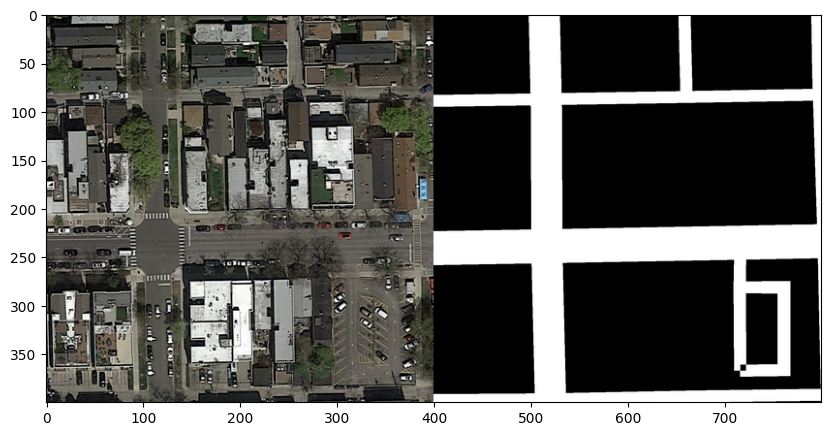

In [ ]:
visualize(myDatas.imgs, myDatas.gt_imgs, index=34)

In [ ]:
myDatas.y_train[0]

1

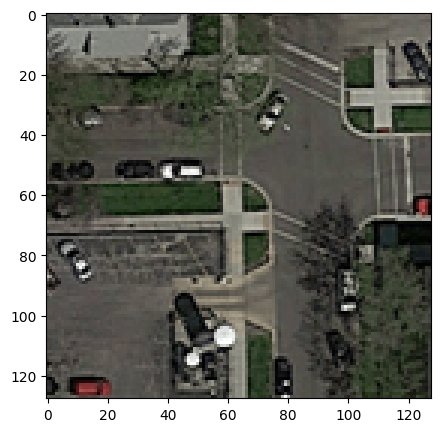

In [ ]:
visualize_patch(myDatas.X_train[0].transpose(1,2,0))

In [ ]:
from data_augmentation import rotate_imgs_train
rotated_imgs,rotated_imgs_gt = rotate_imgs_train(myDatas.imgs[34:35],myDatas.gt_imgs[34:35])

Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees


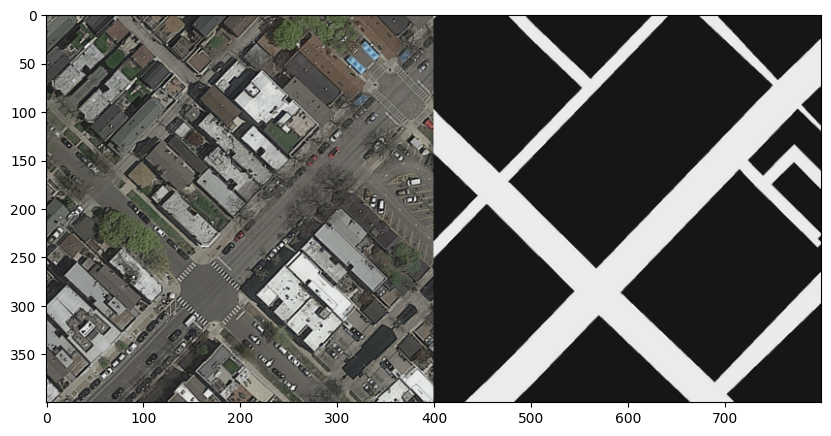

In [ ]:
visualize(rotated_imgs, rotated_imgs_gt, index=0)

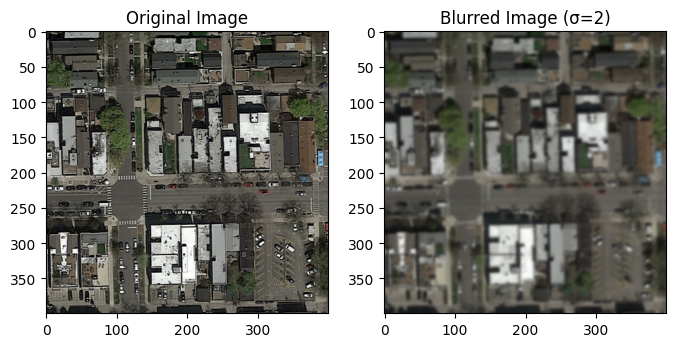

In [ ]:
from scipy.ndimage import gaussian_filter
# Display the original and blurred images
image = myDatas.imgs[34]
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)  # Convert back to uint8 for display
plt.title('Original Image')
blurred_image = np.zeros_like(image)
for channel in range(image.shape[2]):
            blurred_image[:, :, channel] = gaussian_filter(image[:, :, channel], constants.SIGMA)
plt.subplot(1, 2, 2)
plt.imshow(blurred_image)  # Convert back to uint8 for display
plt.title('Blurred Image (σ={})'.format(constants.SIGMA))

plt.show()

## 2. Define and train models

### 2.1 Logistic regression

A first attempt could be to try with some linear model. The first approach here is to use a simple logistic regression. In order to use a logistic regression, one need to extract feature from the image. A choice could be to use the mean and the standard deviation as features. The following section will present these approach.

In [ ]:
LogisticData = BasicProcessing()
LogisticData.load_data()
LogisticData.create_patches()

Loading data...
Done!
Creating patches...
Done!


In [ ]:
LogReg = LogisticRegression(LogisticData.imgs_patches, LogisticData.gt_imgs_patches)
LogReg.compute_vectors()

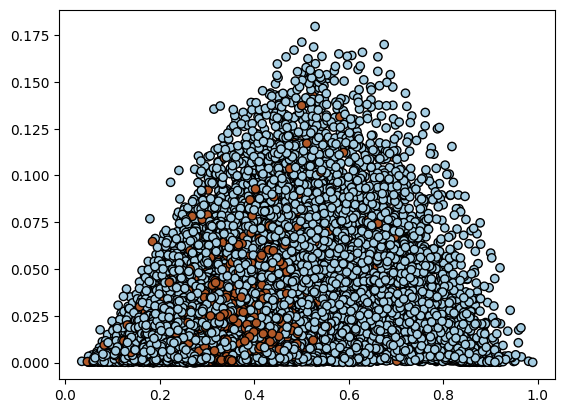

In [ ]:
plt.scatter(LogReg.X[:, 0], LogReg.X[:, 1], c=LogReg.Y, edgecolors="k", cmap=plt.cm.Paired)
plt.show()

A problem already arises. The datas are not linearly separable. Let's still try to train the model.

In [ ]:
LogReg.train()
LogReg.predict()

In [ ]:
print(f'From this model, the accuracy is {LogReg.accuracy*100:.2f}% and the F1 score is {LogReg.f1*100:.2f}%')

From this model, the accuracy is 55.08% and the F1 score is 44.22%


The unsatisfactory results tend us to move to Convolutional Networks, which are more suitable for image datas.

### 2.2 Basic Convolutional Neural Network

In [11]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

#### Try with basic processing

In [26]:
myDatas = BasicProcessing()
myDatas.proceed()

Loading data...
Done!
Creating patches...
Done!
Creating labels...
Done!
Permuting axis...
Done!
Splitting data...
Done!
Creating dataloader...
Done!


In [27]:

# Define the model
cnn = Basic_CNN(patch_size = 16)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = 'basic_cnn_basic_process.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Epoch 1/20, Loss: 0.4461575637626648, Validation Accuracy: 0.7933, F1 score: 0.4988
Epoch 2/20, Loss: 0.4109469823455811, Validation Accuracy: 0.7880, F1 score: 0.4061
Epoch 3/20, Loss: 0.40915465486526487, Validation Accuracy: 0.8062, F1 score: 0.5894
Epoch 4/20, Loss: 0.3876797645187378, Validation Accuracy: 0.8117, F1 score: 0.5364
Epoch 5/20, Loss: 0.3840297687911987, Validation Accuracy: 0.8186, F1 score: 0.5743
Epoch 6/20, Loss: 0.37409361166000366, Validation Accuracy: 0.8216, F1 score: 0.5857
Epoch 7/20, Loss: 0.3726249455833435, Validation Accuracy: 0.8170, F1 score: 0.5471
Epoch 8/20, Loss: 0.38549500967025757, Validation Accuracy: 0.8222, F1 score: 0.6130
Epoch 9/20, Loss: 0.3726557004928589, Validation Accuracy: 0.8206, F1 score: 0.5736
Epoch 10/20, Loss: 0.3780197667503357, Validation Accuracy: 0.8314, F1 score: 0.6461
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/20, Loss: 0.361165745677948, Validation Accuracy: 0.8341, F1 score: 0.6408
Epoch 12/2

#### Training on different patch size

Basic model

In [ ]:
# Define the patch size
patch_size = 16

# Load data
myDatas = AdvancedProcessing(standardize=False, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Basic_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'basic_cnn_{patch_size}.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.4934361844901531, Validation Accuracy: 0.7759, F1 score: 0.6367
Epoch 2/20, Loss: 0.5183074285556888, Validation Accuracy: 0.7775, F1 score: 0.6565
Epoch 3/20, Loss: 0.43794092928603057, Validation Accuracy: 0.8077, F1 score: 0.6781
Epoch 4/20, Loss: 0.49082950261111663, Validation Accuracy: 0.7817, F1 score: 0.6659
Epoch 5/20, Loss: 0.4547062020530086, Validation Accuracy: 0.8010, F1 score: 0.6683
Epoch 6/20, Loss: 0.5330892101422557, Validation Accuracy: 0.7709, F1 score: 0.6563
Epoch 00006: reducing learning rate of group 0 t

In [ ]:
patch_size = 32

# Load data
myDatas = AdvancedProcessing(standardize=False, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Basic_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'basic_cnn_{patch_size}.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.4807708620887296, Validation Accuracy: 0.7845, F1 score: 0.6685
Epoch 2/20, Loss: 0.4845701543321309, Validation Accuracy: 0.8066, F1 score: 0.6943
Epoch 3/20, Loss: 0.4449634189231612, Validation Accuracy: 0.8130, F1 score: 0.7052
Epoch 4/20, Loss: 0.49883153481761155, Validation Accuracy: 0.7879, F1 score: 0.6794
Epoch 5/20, Loss: 0.45339902617653044, Validation Accuracy: 0.8224, F1 score: 0.7124
Epoch 6/20, Loss: 0.3988926369845101, Validation Accuracy: 0.8328, F1 score: 0.7074
Epoch 7/20, Loss: 0.43023943461534925, Validatio

In [ ]:
patch_size = 64

# Load data
myDatas = AdvancedProcessing(standardize=False, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Basic_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'basic_cnn_{patch_size}.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.4131178444552217, Validation Accuracy: 0.8254, F1 score: 0.6910
Epoch 2/20, Loss: 0.4146678594466776, Validation Accuracy: 0.8274, F1 score: 0.7171
Epoch 3/20, Loss: 0.46791669316769446, Validation Accuracy: 0.8147, F1 score: 0.6982
Epoch 4/20, Loss: 0.4195535041989836, Validation Accuracy: 0.8277, F1 score: 0.7153
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/20, Loss: 0.3882252540346401, Validation Accuracy: 0.8452, F1 score: 0.7353
Epoch 6/20, Loss: 0.3759030193490682, Validation Accuracy: 0.8494, F1 s

Advanced CNN

In [ ]:
patch_size = 64

# Load data
myDatas = AdvancedProcessing(standardize=False, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.2847118457419786, Validation Accuracy: 0.8768, F1 score: 0.7554
Epoch 2/20, Loss: 0.32254580433648744, Validation Accuracy: 0.8621, F1 score: 0.7566
Epoch 3/20, Loss: 0.33485483132923255, Validation Accuracy: 0.8750, F1 score: 0.7833
Epoch 4/20, Loss: 0.32979493105174806, Validation Accuracy: 0.8798, F1 score: 0.7788
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/20, Loss: 0.3717337944957472, Validation Accuracy: 0.8839, F1 score: 0.7857
Epoch 6/20, Loss: 0.3806681300994322, Validation Accuracy: 0.8874, F1

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=False, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.30558714373350143, Validation Accuracy: 0.8735, F1 score: 0.7750
Epoch 2/20, Loss: 0.28065070772200823, Validation Accuracy: 0.8844, F1 score: 0.7689
Epoch 3/20, Loss: 0.28121130380625603, Validation Accuracy: 0.8938, F1 score: 0.8112
Epoch 4/20, Loss: 0.28314186359588156, Validation Accuracy: 0.9074, F1 score: 0.8161
Epoch 5/20, Loss: 0.3519300296036704, Validation Accuracy: 0.9005, F1 score: 0.7985
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/20, Loss: 0.32002940900370375, Validation Accuracy: 0.9136, 

#### Color standarization

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_color_{patch_size}.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.2548063409280027, Validation Accuracy: 0.8974, F1 score: 0.8131
Epoch 2/20, Loss: 0.27572835641408594, Validation Accuracy: 0.8971, F1 score: 0.8150
Epoch 3/20, Loss: 0.26852619592154336, Validation Accuracy: 0.9004, F1 score: 0.8267
Epoch 4/20, Loss: 0.2763398114823931, Validation Accuracy: 0.9096, F1 score: 0.8308
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/20, Loss: 0.26881204169645606, Validation Accuracy: 0.9259, F1 score: 0.8589
Epoch 6/20, Loss: 0.2891112199130235, Validati

#### Different optimizer

AdamW

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}_adamw.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.28956350170035844, Validation Accuracy: 0.8874, F1 score: 0.7987
Epoch 2/20, Loss: 0.29829051400687084, Validation Accuracy: 0.8962, F1 score: 0.8141
Epoch 3/20, Loss: 0.26698061458424316, Validation Accuracy: 0.9027, F1 score: 0.8293
Epoch 4/20, Loss: 0.2938654332827677, Validation Accuracy: 0.9134, F1 score: 0.8358
Epoch 5/20, Loss: 0.2909481479131503, Validation Accuracy: 0.9070, F1 score: 0.8254
Epoch 6/20, Loss: 0.2793161032093547, Validation Accuracy: 0.9074, F1 score: 0.8345
Epoch 00006: reducing le

SGD with Nesterov Momentum

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size)

# Define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9, nesterov=True)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}_nesterov.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.5980667349433899, Validation Accuracy: 0.7372, F1 score: 0.6085
Epoch 2/20, Loss: 0.42247442523956297, Validation Accuracy: 0.8303, F1 score: 0.7005
Epoch 3/20, Loss: 0.32990767721176145, Validation Accuracy: 0.8734, F1 score: 0.7626
Epoch 4/20, Loss: 0.30886016063451766, Validation Accuracy: 0.8782, F1 score: 0.7814
Epoch 5/20, Loss: 0.25458831061124804, Validation Accuracy: 0.8968, F1 score: 0.8025
Epoch 6/20, Loss: 0.28739350912332534, Validation Accuracy: 0.8861, F1 score: 0.8024
Epoch 7/20, Loss: 0.24

#### Different thresholds

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size,threshold=0.3)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}_thr_03.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.2762996203779895, Validation Accuracy: 0.8883, F1 score: 0.8023
Epoch 2/20, Loss: 0.2965825154450778, Validation Accuracy: 0.8862, F1 score: 0.8051
Epoch 3/20, Loss: 0.24435993702110723, Validation Accuracy: 0.9046, F1 score: 0.8311
Epoch 4/20, Loss: 0.2916551399582182, Validation Accuracy: 0.9108, F1 score: 0.8265
Epoch 5/20, Loss: 0.25820654888439754, Validation Accuracy: 0.9104, F1 score: 0.8323
Epoch 6/20, Loss: 0.29548749530934265, Validation Accuracy: 0.9033, F1 score: 0.8226
Epoch 00006: reducing le

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size,threshold=0.2)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}_thr_02.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.2613459303090023, Validation Accuracy: 0.8951, F1 score: 0.8138
Epoch 2/20, Loss: 0.2763431610815179, Validation Accuracy: 0.9055, F1 score: 0.8272
Epoch 3/20, Loss: 0.27150074618973086, Validation Accuracy: 0.8970, F1 score: 0.8165
Epoch 4/20, Loss: 0.28712252545690464, Validation Accuracy: 0.9092, F1 score: 0.8311
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/20, Loss: 0.2606708172011612, Validation Accuracy: 0.9235, F1 score: 0.8547
Epoch 6/20, Loss: 0.26724828177032073, Validati

## With Blur

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size, blur = True)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size,threshold=0.2)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}_blur.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.3000157855558819, Validation Accuracy: 0.8825, F1 score: 0.7979
Epoch 2/20, Loss: 0.2980860681059182, Validation Accuracy: 0.8942, F1 score: 0.8090
Epoch 3/20, Loss: 0.28523921466871704, Validation Accuracy: 0.8978, F1 score: 0.8213
Epoch 4/20, Loss: 0.29093355419050765, Validation Accuracy: 0.9030, F1 score: 0.8228
Epoch 5/20, Loss: 0.3072106586480845, Validation Accuracy: 0.9017, F1 score: 0.8100
Epoch 6/20, Loss: 0.2742891971480875, Validation Accuracy: 0.9130, F1 score: 0.8406
Epoch 7/20, Loss: 0.31790

In [ ]:
patch_size = 128

# Load data
myDatas = AdvancedProcessing(standardize=True, aug_patch_size=patch_size, blur = True)
myDatas.proceed()

# Define the model
cnn = Advanced_CNN(patch_size,threshold=0.25)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=20)

torch_file_name = f'advanced_cnn_{patch_size}_blur_025.pth'
# Save the model
torch.save(cnn, os.path.join(MODELS_DIR, torch_file_name))
del myDatas

Loading data...
Done!
Standardizing...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!
Epoch 1/20, Loss: 0.25310423214312644, Validation Accuracy: 0.8930, F1 score: 0.8000
Epoch 2/20, Loss: 0.285267102347872, Validation Accuracy: 0.8935, F1 score: 0.8113
Epoch 3/20, Loss: 0.2611116255716527, Validation Accuracy: 0.9098, F1 score: 0.8188
Epoch 4/20, Loss: 0.30479687640534237, Validation Accuracy: 0.9003, F1 score: 0.8111
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/20, Loss: 0.2798074968274523, Validation Accuracy: 0.9125, F1 score: 0.8381
Epoch 6/20, Loss: 0.3347160268901021, Validation

In [35]:
best_model = torch.load('../models/advanced_cnn_128_blur.pth', map_location=constants.DEVICE)

In [33]:
MyTestData = TestData(standardize=True, aug_patch_size=128)
MyTestData.proceed()

Loading data...
Done!
Standardizing...
Done!
Formatting data...
Done!
Creating dataloader...
Done!


In [36]:
preds = best_model.predict(MyTestData.test_dataloader)

In [62]:
from visualization import visualize_solution

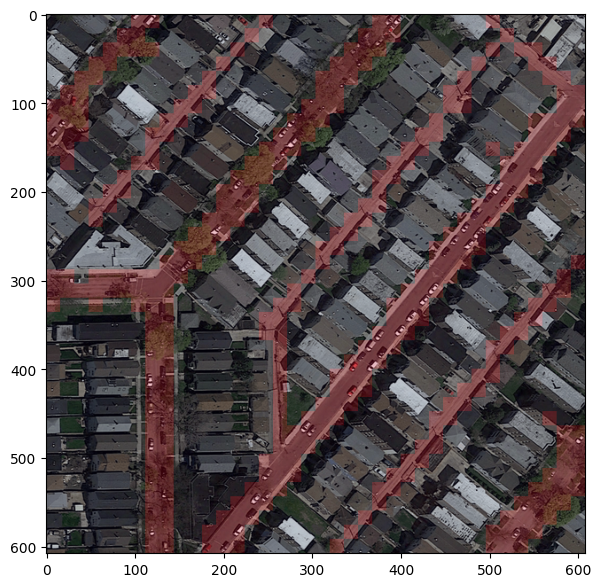

In [78]:
idx_img = 47
img = MyTestData.imgs[idx_img]
visualize_solution(
    img = img,
    idx_img = idx_img,
    prediction = preds)